<a href="https://colab.research.google.com/github/EmmaCOo/ADS509_Text_Mining_Final_Project/blob/main/Final_Project_Descriptive_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**ADS509_TEXT_MINING_FINAL_PROJECT - DESCRIPTIVE STATISTICS**

**Sindhu Bhattarai, Emma Oo, Sean Torres**



In [ ]:
!pip install emoji==1.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 29.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=6e357a188a6b785f8091acfd0089218e79596361631a6ce0ddcd678d4a327256
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('stopwords')
sw = stopwords.words("english")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
import html 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#load all csv files
burger = pd.read_csv('/content/drive/MyDrive/TM_Final/BurgerKing_followers.txt', sep = '\t')
jackbox = pd.read_csv('/content/drive/MyDrive/TM_Final/JackBox_followers.txt', sep = '\t')
inn = pd.read_csv('/content/drive/MyDrive/TM_Final/innoutburger_followers.txt',sep = '\t')
chickfila = pd.read_csv('/content/drive/MyDrive/TM_Final/ChickfilA_followers.txt',sep = '\t')
sonic = pd.read_csv('/content/drive/MyDrive/TM_Final/sonicdrivein_followers.txt',sep = '\t')

In [ ]:
#Drop all records with Na description
burger_df = burger[burger["description"].str.strip().str.len()>0]
jackbox_df = jackbox[jackbox["description"].str.strip().str.len()>0]
inn_df = inn[inn["description"].str.strip().str.len()>0]
chick_df = chickfila[chickfila["description"].str.strip().str.len()>0]
sonic_df = sonic[sonic["description"].str.strip().str.len()>0]

In [ ]:
#print the shape of each dataset
burger_df.shape, jackbox_df.shape, inn_df.shape, chick_df.shape, sonic_df.shape

((57325, 8), (36006, 8), (57329, 8), (68737, 8), (59924, 8))

In [ ]:
#Add the class columns to each dataframe
burger_df['chain'] = 'BurgerKing'
jackbox_df['chain'] = 'JackInTheBox'
inn_df['chain'] = 'Inn-N-Out'
chick_df['chain'] = 'Chick-Fil-A'
sonic_df['chain'] = 'Sonic'

#Merge all dataframes
frames = [burger_df, jackbox_df, inn_df, chick_df, sonic_df]
df = pd.concat(frames)
df.shape

(279321, 9)

In [ ]:
df.head()

,ID,screen_name,name,location,follower_count,friends_count,like_count,description,chain
1,1475906563625865217,marcoShiva112,marcoShiva112,NaN,2,9,NaN,From Marcos (individual personality) to Shiva ...,BurgerKing
3,1361777286555525126,youngenaru,Enaru_,NaN,2,161,NaN,I am Polish youtuber. lol,BurgerKing
4,1485475728091414530,onyxx772,onyxx77,NaN,0,11,NaN,m,BurgerKing
5,1080764161603371008,Waqarali5075,SmarTboy 🇵🇰🇹🇷🛩,"کراچی, پاکستان",567,4447,NaN,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing
7,1571456733918134279,Sarah_John120,Sarah Johnston,"Birmingham, England",127,3166,NaN,26| So proud to be Scottish. World is wide. le...,BurgerKing


In [ ]:
#substract only descriptin (text data) and classes
text_df = df[['description','chain']]
text_df.head()

,description,chain
1,From Marcos (individual personality) to Shiva ...,BurgerKing
3,I am Polish youtuber. lol,BurgerKing
4,m,BurgerKing
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing
7,26| So proud to be Scottish. World is wide. le...,BurgerKing


In [ ]:
punctuation = set(punctuation) # speeds up comparison

def remove_punc(text):
  text_nonpunc ="".join([char for char in text if char not in punctuation])
  return text_nonpunc

# Define Tokenization Function
#To keep the emojis while tokenizing
RE_TOKEN = re.compile(r"""
                   ( [#]?[@\w'’\.\-\:]*\w     # words, hashtags and email addresses
                   | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
                   | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
                   )
                  """, re.VERBOSE)

def tokenize(text):
  return text.split()

# Define Stop Words Remove Function
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(text):
  return [t for t in text if t not in stopwords]


# Define pipeline of lowering, no punctuation, tokenization, and removal of stopwords
pipeline = [str.lower, remove_punc,tokenize, remove_stop]
def prepare(text, pipeline): 
  tokens = text
  for transform in pipeline: tokens = transform(tokens)
  return tokens

In [ ]:
# change the data frame to string data types
text_df = text_df.astype(str)

#replace Na values with '' 
text_df['description'] = text_df['description'].replace(np.nan, '')

In [ ]:
text_df['tokens'] = text_df['description'].apply(prepare, pipeline = pipeline)
text_df.head()

,description,chain,tokens
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc..."
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]"
4,m,BurgerKing,[]
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]"
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ..."


In [ ]:
text_df['length_before_cleaning'] = text_df['description'].apply(lambda x: len(x))  # length of raw texts
text_df['length_after_cleaning'] = text_df['tokens'].apply(lambda x: len(x))  # length of cleand words
text_df.head()

,description,chain,tokens,length_before_cleaning,length_after_cleaning
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc...",159,14
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]",25,3
4,m,BurgerKing,[],1,0
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]",40,7
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ...",70,8


In [ ]:
#Distribution of each cain
df['chain'].value_counts()

Chick-Fil-A     68737
Sonic           59924
Inn-N-Out       57329
BurgerKing      57325
JackInTheBox    36006
Name: chain, dtype: int64

Text(0.5, 1.0, 'Distribution of Burger Chains')

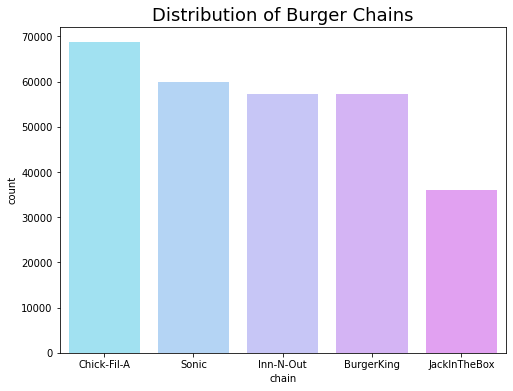

In [ ]:
# Figur size
plt.figure(figsize=(8,6))

# countplot
sns.countplot( x = 'chain', data = text_df, palette = 'cool', alpha = 0.5, order = text_df['chain'].value_counts().index)

# Add title
plt.title('Distribution of Burger Chains', fontsize=18)

###**DESCRIPTIVE STATISTICS**


In [ ]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    
    #filled na with whitespace to work with df and making sure it will
    #not be counted on frequent words
    tokens = [token for token in tokens if token not in ['', " "]]
    # Fill in the correct values here. 
    num_tokens =  len(tokens)
    num_unique_tokens = len(set(tokens)) #len(np.unique(tokens))
    lexical_diversity =  len(set(tokens)) / len(tokens) 
    num_characters =  sum([len(i) for i in tokens]) 
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5))

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [ ]:
#BURGER KING
burger_king_df = text_df[text_df['chain'].str.contains('BurgerKing')]
token_burgerking = []
for i in burger_king_df['tokens']:
    token_burgerking.extend(i)    
print('Descriptive Stats of BURGER KING follower description text token:')
descriptive_stats(token_burgerking)

#JACK IN THE BOX
jackbox_df = text_df[text_df['chain'].str.contains('JackInTheBox')]
token_jack = []
for i in jackbox_df['tokens']:
    token_jack.extend(i)
print('\n')
print('Descriptive Stats of JACK-IN-THE-BOX follower description text token:')
descriptive_stats(token_jack)

#Inn-N-Out
innout_df = text_df[text_df['chain'].str.contains('Inn-N-Out')]
token_inn = []
for i in innout_df['tokens']:
    token_inn.extend(i)
print('\n')
print('Descriptive Stats of INN-N-OUT follower description text token:')
descriptive_stats(token_inn)

#CHICK-FIL-A
chickfila_df = text_df[text_df['chain'].str.contains('Chick-Fil-A')]
token_chick = []
for i in chickfila_df['tokens']:
    token_chick.extend(i)
print('\n')
print('Descriptive Stats of CHICK-FIL-A follower description text token:')
descriptive_stats(token_chick)

#SONIC DRIVE IN
sonicdrive_df = text_df[text_df['chain'].str.contains('Sonic')]
token_sonic = []
for i in sonicdrive_df['tokens']:
    token_sonic.extend(i)
print('\n')
print('Descriptive Stats of SONIC-DRIVEIN follower description text token:')
descriptive_stats(token_sonic)

Descriptive Stats of BURGER KING follower description text token:
There are 361512 tokens in the data.
There are 89563 unique tokens in the data.
There are 2091824 characters in the data.
The lexical diversity is 0.248 in the data.
[('love', 4000), ('im', 3787), ('like', 2170), ('life', 1965), ('fan', 1505)]


Descriptive Stats of JACK-IN-THE-BOX follower description text token:
There are 301140 tokens in the data.
There are 67050 unique tokens in the data.
There are 1847325 characters in the data.
The lexical diversity is 0.223 in the data.
[('love', 2306), ('life', 1840), ('fan', 1653), ('im', 1447), ('•', 1304)]


Descriptive Stats of INN-N-OUT follower description text token:
There are 361475 tokens in the data.
There are 89558 unique tokens in the data.
There are 2091679 characters in the data.
The lexical diversity is 0.248 in the data.
[('love', 4001), ('im', 3786), ('like', 2172), ('life', 1966), ('fan', 1505)]


Descriptive Stats of CHICK-FIL-A follower description text token:

[401075, 84136, 0.20977622639157265, 2350044]

In [ ]:
text_df['tokens_str'] = text_df['tokens'].str.join(" ")
text_df.head()

,description,chain,tokens,length_before_cleaning,length_after_cleaning,tokens_str
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc...",159,14,marcos individual personality shiva source cre...
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]",25,3,polish youtuber lol
4,m,BurgerKing,[],1,0,
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]",40,7,✈‏aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ...",70,8,26 proud scottish world wide let make samememo...
